In [1]:
import os
import sys
import math
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
class Node:
    def __init__(self, n):
        self.x = n[0]
        self.y = n[1]
        self.parent = None

In [ ]:
class Env:
    def __init__(self):
        self.x_range = (0, 50)
        self.y_range = (0, 30)
        self.obs_boundary = self.obs_boundary()
        self.obs_circle = self.obs_circle()
        self.obs_rectangle = self.obs_rectangle()

    @staticmethod
    def obs_boundary():
        obs_boundary = [
            [0, 0, 1, 30],
            [0, 30, 50, 1],
            [1, 0, 50, 1],
            [50, 1, 1, 30]
        ]
        return obs_boundary

    @staticmethod
    def obs_rectangle():
        obs_rectangle = [
            [14, 12, 8, 2],
            [18, 22, 8, 3],
            [26, 7, 2, 12],
            [32, 14, 10, 2]
        ]
        return obs_rectangle

    @staticmethod
    def obs_circle():
        obs_cir = [
            [7, 12, 3],
            [46, 20, 2],
            [15, 5, 2],
            [37, 7, 3],
            [37, 23, 3]
        ]

        return obs_cir

In [ ]:
class Plotting:
    def __init__(self, x_start, x_goal):
        self.xI, self.xG = x_start, x_goal
        self.env = Env()
        self.obs_bound = self.env.obs_boundary
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle

    def animation(self, nodelist, path, name, animation=False):
        self.plot_grid(name)
        self.plot_visited(nodelist, animation)
        self.plot_path(path)

    def animation_connect(self, V1, V2, path, name):
        self.plot_grid(name)
        self.plot_visited_connect(V1, V2)
        self.plot_path(path)

    def plot_grid(self, name):
        fig, ax = plt.subplots()

        for (ox, oy, w, h) in self.obs_bound:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='black',
                    fill=True
                )
            )

        for (ox, oy, w, h) in self.obs_rectangle:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        for (ox, oy, r) in self.obs_circle:
            ax.add_patch(
                patches.Circle(
                    (ox, oy), r,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        plt.plot(self.xI[0], self.xI[1], "bs", linewidth=3)
        plt.plot(self.xG[0], self.xG[1], "gs", linewidth=3)

        plt.title(name)
        plt.axis("equal")

    @staticmethod
    def plot_visited(nodelist, animation):
        if animation:
            count = 0
            for node in nodelist:
                count += 1
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")
                    plt.gcf().canvas.mpl_connect('key_release_event',
                                                 lambda event:
                                                 [exit(0) if event.key == 'escape' else None])
                    if count % 10 == 0:
                        plt.pause(0.001)
        else:
            for node in nodelist:
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")

    @staticmethod
    def plot_visited_connect(V1, V2):
        len1, len2 = len(V1), len(V2)

        for k in range(max(len1, len2)):
            if k < len1:
                if V1[k].parent:
                    plt.plot([V1[k].x, V1[k].parent.x], [V1[k].y, V1[k].parent.y], "-g")
            if k < len2:
                if V2[k].parent:
                    plt.plot([V2[k].x, V2[k].parent.x], [V2[k].y, V2[k].parent.y], "-g")

            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if k % 2 == 0:
                plt.pause(0.001)

        plt.pause(0.01)

    @staticmethod
    def plot_path(path):
        if len(path) != 0:
            plt.plot([x[0] for x in path], [x[1] for x in path], '-r', linewidth=2)
            plt.pause(0.01)
        plt.show()

In [ ]:
class Utils:
    def __init__(self):
        self.env = Env()

        self.delta = 0.5
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle
        self.obs_boundary = self.env.obs_boundary

    def update_obs(self, obs_cir, obs_bound, obs_rec):
        self.obs_circle = obs_cir
        self.obs_boundary = obs_bound
        self.obs_rectangle = obs_rec

    def get_obs_vertex(self):
        delta = self.delta
        obs_list = []

        for (ox, oy, w, h) in self.obs_rectangle:
            vertex_list = [[ox - delta, oy - delta],
                           [ox + w + delta, oy - delta],
                           [ox + w + delta, oy + h + delta],
                           [ox - delta, oy + h + delta]]
            obs_list.append(vertex_list)

        return obs_list

    def is_intersect_rec(self, start, end, o, d, a, b):
        v1 = [o[0] - a[0], o[1] - a[1]]
        v2 = [b[0] - a[0], b[1] - a[1]]
        v3 = [-d[1], d[0]]

        div = np.dot(v2, v3)

        if div == 0:
            return False

        t1 = np.linalg.norm(np.cross(v2, v1)) / div
        t2 = np.dot(v1, v3) / div

        if t1 >= 0 and 0 <= t2 <= 1:
            shot = Node((o[0] + t1 * d[0], o[1] + t1 * d[1]))
            dist_obs = self.get_dist(start, shot)
            dist_seg = self.get_dist(start, end)
            if dist_obs <= dist_seg:
                return True

        return False

    def is_intersect_circle(self, o, d, a, r):
        d2 = np.dot(d, d)
        delta = self.delta

        if d2 == 0:
            return False

        t = np.dot([a[0] - o[0], a[1] - o[1]], d) / d2

        if 0 <= t <= 1:
            shot = Node((o[0] + t * d[0], o[1] + t * d[1]))
            if self.get_dist(shot, Node(a)) <= r + delta:
                return True

        return False

    def is_collision(self, start, end):
        if self.is_inside_obs(start) or self.is_inside_obs(end):
            return True

        o, d = self.get_ray(start, end)
        obs_vertex = self.get_obs_vertex()

        for (v1, v2, v3, v4) in obs_vertex:
            if self.is_intersect_rec(start, end, o, d, v1, v2):
                return True
            if self.is_intersect_rec(start, end, o, d, v2, v3):
                return True
            if self.is_intersect_rec(start, end, o, d, v3, v4):
                return True
            if self.is_intersect_rec(start, end, o, d, v4, v1):
                return True

        for (x, y, r) in self.obs_circle:
            if self.is_intersect_circle(o, d, [x, y], r):
                return True

        return False

    def is_inside_obs(self, node):
        delta = self.delta

        for (x, y, r) in self.obs_circle:
            if math.hypot(node.x - x, node.y - y) <= r + delta:
                return True

        for (x, y, w, h) in self.obs_rectangle:
            if 0 <= node.x - (x - delta) <= w + 2 * delta \
                    and 0 <= node.y - (y - delta) <= h + 2 * delta:
                return True

        for (x, y, w, h) in self.obs_boundary:
            if 0 <= node.x - (x - delta) <= w + 2 * delta \
                    and 0 <= node.y - (y - delta) <= h + 2 * delta:
                return True

        return False

    @staticmethod
    def get_ray(start, end):
        orig = [start.x, start.y]
        direc = [end.x - start.x, end.y - start.y]
        return orig, direc

    @staticmethod
    def get_dist(start, end):
        return math.hypot(end.x - start.x, end.y - start.y)

In [ ]:
class ExtendedRrt:
    def __init__(self, s_start, s_goal, step_len, goal_sample_rate, waypoint_sample_rate, iter_max):
        self.s_start = Node(s_start)
        self.s_goal = Node(s_goal)
        self.step_len = step_len
        self.goal_sample_rate = goal_sample_rate
        self.waypoint_sample_rate = waypoint_sample_rate
        self.iter_max = iter_max
        self.vertex = [self.s_start]

        self.env = Env()
        self.plotting = Plotting(s_start, s_goal)
        self.utils = Utils()
        self.fig, self.ax = plt.subplots()

        self.x_range = self.env.x_range
        self.y_range = self.env.y_range
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle
        self.obs_boundary = self.env.obs_boundary

        self.path = []
        self.waypoint = []

    def planning(self):
        for i in range(self.iter_max):
            node_rand = self.generate_random_node(self.goal_sample_rate)
            node_near = self.nearest_neighbor(self.vertex, node_rand)
            node_new = self.new_state(node_near, node_rand)

            if node_new and not self.utils.is_collision(node_near, node_new):
                self.vertex.append(node_new)
                dist, _ = self.get_distance_and_angle(node_new, self.s_goal)

                if dist <= self.step_len:
                    self.new_state(node_new, self.s_goal)

                    path = self.extract_path(node_new)
                    self.plot_grid("Extended_RRT")
                    self.plot_visited()
                    self.plot_path(path)
                    self.path = path
                    self.waypoint = self.extract_waypoint(node_new)
                    self.fig.canvas.mpl_connect('button_press_event', self.on_press)
                    plt.show()

                    return

        return None

    def on_press(self, event):
        print("Press")
        x, y = event.xdata, event.ydata
        if x < 0 or x > 50 or y < 0 or y > 30:
            print("Please choose right area!")
        else:
            x, y = int(x), int(y)
            print("Add circle obstacle at: s =", x, ",", "y =", y)
            self.obs_circle.append([x, y, 2])
            self.utils.update_obs(self.obs_circle, self.obs_boundary, self.obs_rectangle)
            path, waypoint = self.replanning()

            plt.cla()
            self.plot_grid("Extended_RRT")
            self.plot_path(self.path, color='blue')
            self.plot_visited()
            self.plot_path(path)
            self.path = path
            self.waypoint = waypoint
            self.fig.canvas.draw_idle()

    def replanning(self):
        self.vertex = [self.s_start]

        for i in range(self.iter_max):
            node_rand = self.generate_random_node_replanning(self.goal_sample_rate, self.waypoint_sample_rate)
            node_near = self.nearest_neighbor(self.vertex, node_rand)
            node_new = self.new_state(node_near, node_rand)

            if node_new and not self.utils.is_collision(node_near, node_new):
                self.vertex.append(node_new)
                dist, _ = self.get_distance_and_angle(node_new, self.s_goal)

                if dist <= self.step_len:
                    self.new_state(node_new, self.s_goal)
                    path = self.extract_path(node_new)
                    waypoint = self.extract_waypoint(node_new)

                    return path, waypoint

        return None

    def generate_random_node(self, goal_sample_rate):
        delta = self.utils.delta

        if np.random.random() > goal_sample_rate:
            return Node((np.random.uniform(self.x_range[0] + delta, self.x_range[1] - delta),
                         np.random.uniform(self.y_range[0] + delta, self.y_range[1] - delta)))

        return self.s_goal

    def generate_random_node_replanning(self, goal_sample_rate, waypoint_sample_rate):
        delta = self.utils.delta
        p = np.random.random()

        if p < goal_sample_rate:
            return self.s_goal
        elif goal_sample_rate < p < goal_sample_rate + waypoint_sample_rate:
            return self.waypoint[np.random.randint(0, len(self.path) - 1)]
        else:
            return Node((np.random.uniform(self.x_range[0] + delta, self.x_range[1] - delta),
                         np.random.uniform(self.y_range[0] + delta, self.y_range[1] - delta)))


    @staticmethod
    def nearest_neighbor(node_list, n):
        return node_list[int(np.argmin([math.hypot(nd.x - n.x, nd.y - n.y)
                                        for nd in node_list]))]

    def new_state(self, node_start, node_end):
        dist, theta = self.get_distance_and_angle(node_start, node_end)

        dist = min(self.step_len, dist)
        node_new = Node((node_start.x + dist * math.cos(theta),
                         node_start.y + dist * math.sin(theta)))
        node_new.parent = node_start

        return node_new

    def extract_path(self, node_end):
        path = [(self.s_goal.x, self.s_goal.y)]
        node_now = node_end

        while node_now.parent is not None:
            node_now = node_now.parent
            path.append((node_now.x, node_now.y))

        return path

    def extract_waypoint(self, node_end):
        waypoint = [self.s_goal]
        node_now = node_end

        while node_now.parent is not None:
            node_now = node_now.parent
            waypoint.append(node_now)

        return waypoint

    @staticmethod
    def get_distance_and_angle(node_start, node_end):
        dx = node_end.x - node_start.x
        dy = node_end.y - node_start.y
        return math.hypot(dx, dy), math.atan2(dy, dx)

    def plot_grid(self, name):

        for (ox, oy, w, h) in self.obs_boundary:
            self.ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='black',
                    fill=True
                )
            )

        for (ox, oy, w, h) in self.obs_rectangle:
            self.ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        for (ox, oy, r) in self.obs_circle:
            self.ax.add_patch(
                patches.Circle(
                    (ox, oy), r,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        plt.plot(self.s_start.x, self.s_start.y, "bs", linewidth=3)
        plt.plot(self.s_goal.x, self.s_goal.y, "gs", linewidth=3)

        plt.title(name)
        plt.axis("equal")

    def plot_visited(self):
        animation = True
        if animation:
            count = 0
            for node in self.vertex:
                count += 1
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")
                    plt.gcf().canvas.mpl_connect('key_release_event',
                                                 lambda event:
                                                 [exit(0) if event.key == 'escape' else None])
                    if count % 10 == 0:
                        plt.pause(0.001)
        else:
            for node in self.vertex:
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")

    @staticmethod
    def plot_path(path, color='red'):
        plt.plot([x[0] for x in path], [x[1] for x in path], linewidth=2, color=color)
        plt.pause(0.01)

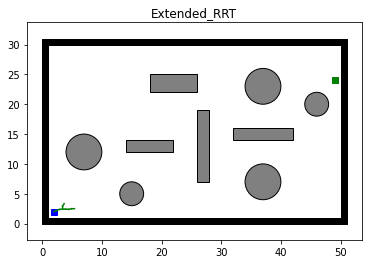

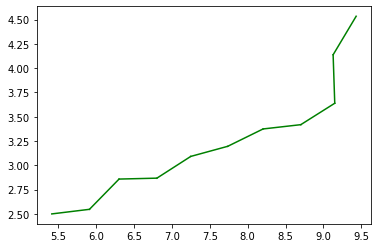

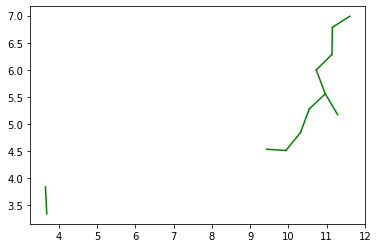

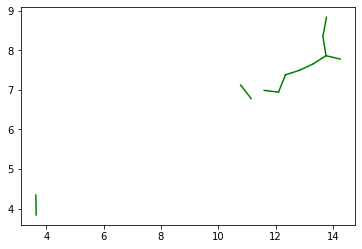

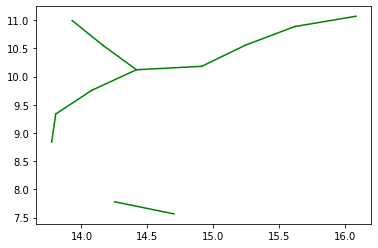

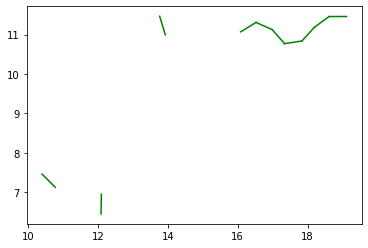

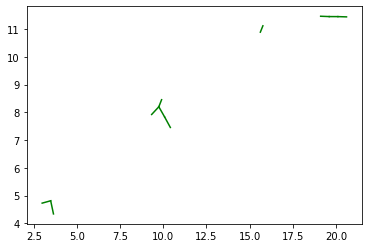

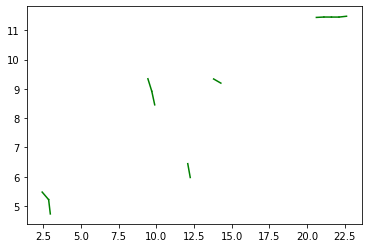

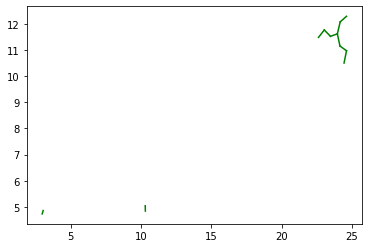

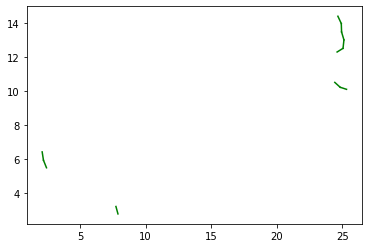

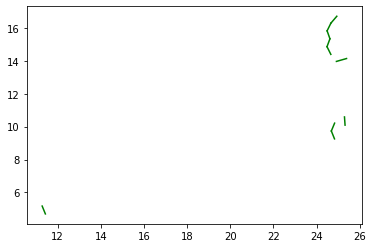

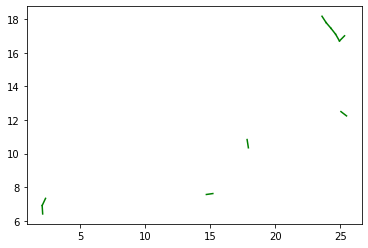

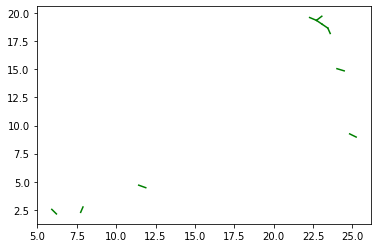

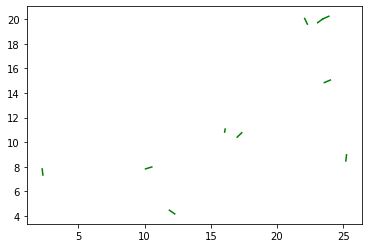

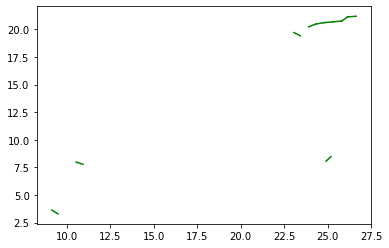

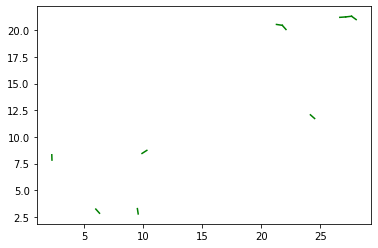

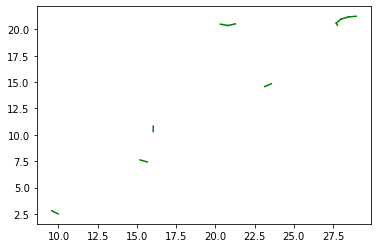

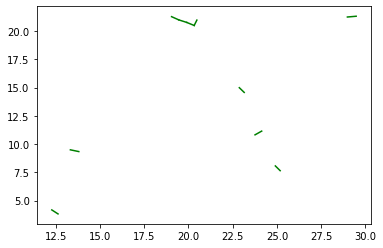

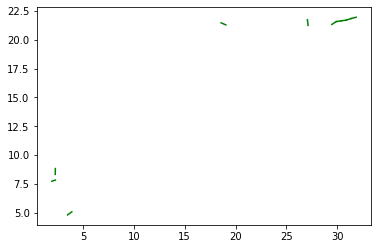

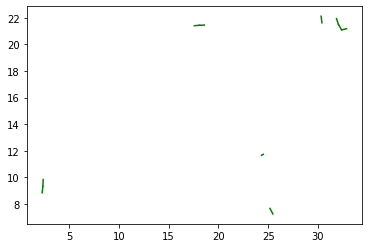

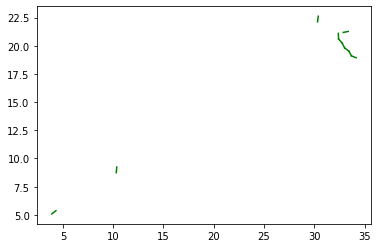

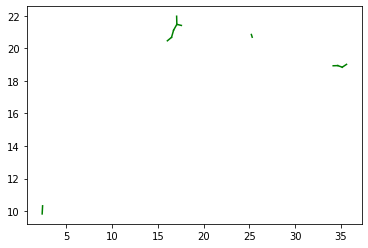

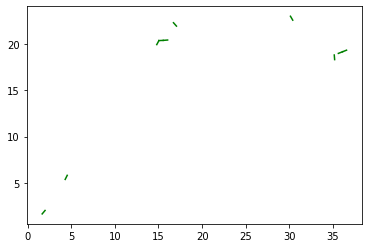

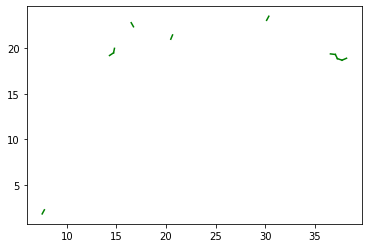

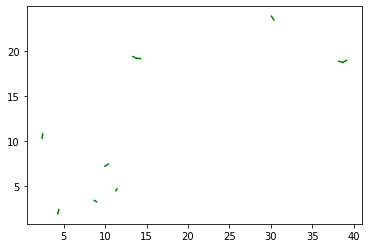

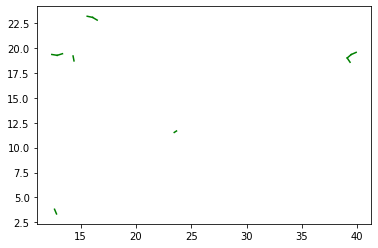

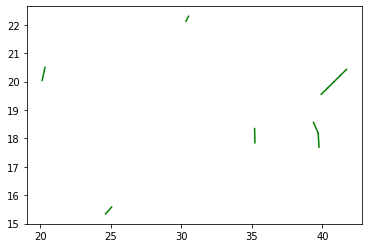

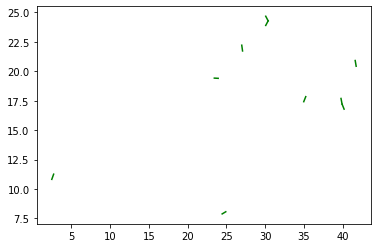

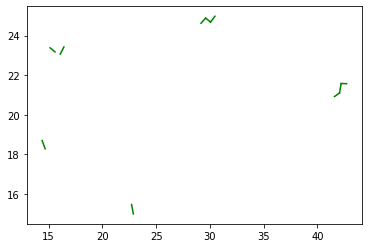

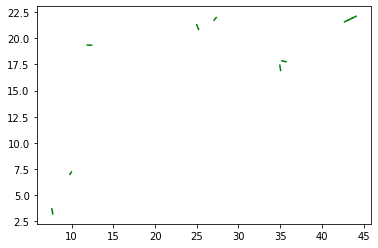

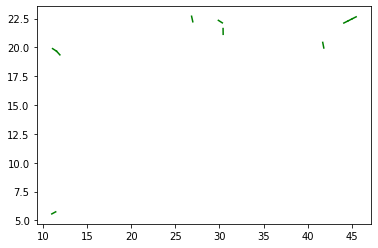

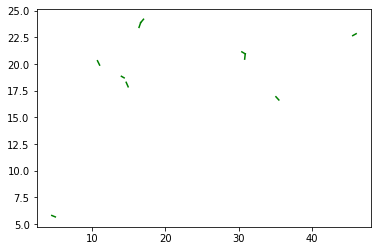

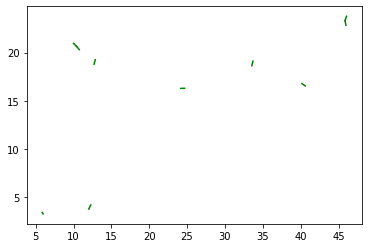

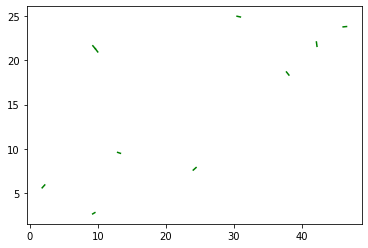

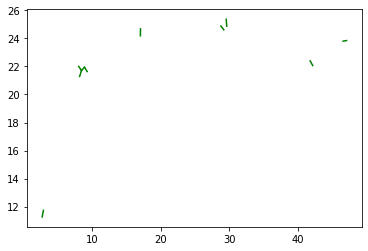

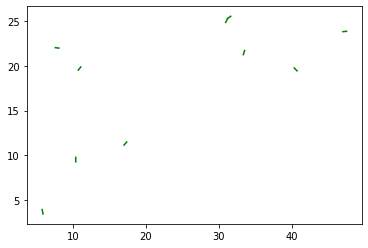

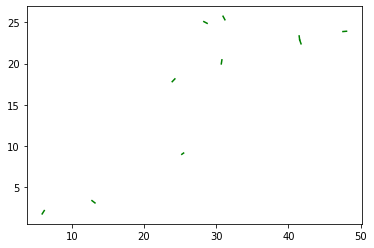

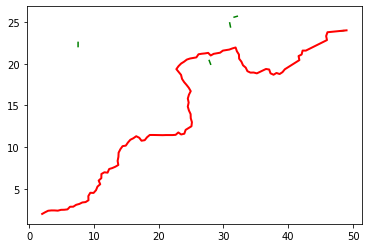

In [ ]:
x_start = (2, 2)  # Starting node
x_goal = (49, 24)  # Goal node

errt = ExtendedRrt(x_start, x_goal, 0.5, 0.1, 0.6, 5000)
errt.planning()